In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
from sklearn.metrics import precision_recall_fscore_support

In [2]:
root_path = os.path.abspath(os.path.join('..', '..'))

In [3]:
def get_model_path(root_path, device, model_type, cv):
    path = root_path
    parent_path = os.path.join(path, 'data', 'Run_logs', device, 'logs')
    # parent paths has three folders for attend, deepCONV, TinyHAR. Get a list of all folders in the parent path
    folders = os.listdir(parent_path)
    for folder in folders:
        if model_type in folder:
            path = os.path.join(parent_path, folder)
            break
    # path now has the path to the model type folder
    path = os.path.join(path, 'cv_' + str(cv))
    return path


def create_confusion(root_path, model_device, test_device, model_type, cv):
    path = get_model_path(root_path, model_device, model_type, cv)
    filename = 'prediction_result_' + model_device + '_' + test_device + '.csv'
    path = os.path.join(path, filename)
    # open the csv file prediction_result_ and read the data
    csv_file = path
    # open with pandas
    df = pd.read_csv(csv_file)
    # if the file is empty, continue
    if df.empty:
        return None

    # get the prediction result
    preds = df['preds'].values
    # get the ground truth
    trues = df['trues'].values

    # Assuming binary classification
    num_classes = 2
    # plot a confusion matrix
    cm = confusion_matrix(trues, preds)
    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


def get_result_for_model(root_path, model_device, test_device, model_type, cv):
    path = get_model_path(root_path, model_device, model_type, cv)
    filename = 'prediction_result_' + model_device + '_' + test_device + '.csv'
    path = os.path.join(path, filename)
    # open the csv file prediction_result_ and read the data
    csv_file = path
    # open with pandas
    df = pd.read_csv(csv_file)
    # if the file is empty, continue
    if df.empty:
        print('Empty file: ', path)
        return None

    # get the prediction result
    preds = df['preds'].values
    # get the ground truth
    trues = df['trues'].values

    # Assuming binary classification
    num_classes = 2

    # Calculate precision, recall, and f1 for each class
    precision, recall, f1, _ = precision_recall_fscore_support(trues, preds, average=None)

    # Calculate accuracy
    accuracy = np.sum(preds == trues) / len(preds)

    # Calculate macro F1
    f1_macro = np.mean(f1)

    # Calculate weighted F1
    class_distribution = np.bincount(trues)
    f1_weighted = np.sum(f1 * class_distribution / len(trues))

    # accuracy = np.sum(preds == trues) / len(preds)
    # precision = np.sum((preds == 1) & (trues == 1)) / np.sum(preds == 1)
    # recall = np.sum((preds == 1) & (trues == 1)) / np.sum(trues == 1)
    # f1 = 2 * np.sum((preds == 1) & (trues == 1)) / (np.sum(preds == 1) + np.sum(trues == 1))
    # f1_w = (precision + recall) / 2

    return accuracy, precision, recall, f1_macro, f1_weighted  #, preds, trues

In [4]:
# Method for creating a multi bar graph with x axis and y axis values in the for of a list
'''
x: list of x axis labels
y: list of y axis values
x_label: x axis label
y_label: y axis label
title: title of the graph
width: width of the graph
height: height of the graph
bar_width: width of each bar
'''
from dataloaders.dataloader_HARVAR_har import HARVAR_CV


def generate_multi_bar_graph(data_frame, x_label, y_label, title, width, height, bar_width, std=False):
    # set the width of the bars
    bar_width = bar_width
    sns.barplot(data_frame, x=x_label, y=y_label, palette='dark', errorbar='sd' if std else None)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.gcf().set_size_inches(width, height)
    plt.show()


def get_f1_df(model_device, test_devices):
    data = {'Device': [], 'F1 Score': [], 'model_type': [], 'cv': []}
    df = pd.DataFrame(data)
    for device in test_devices:
        for i in range(num_participants):
            new_row = {'Device': device,
                       'F1 Score': get_result_for_model(root_path, model_device, device, 'attend', i)[3],
                       'model_type': 'attend',
                       'cv': i}
            df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
            new_row = {'Device': device,
                       'F1 Score': get_result_for_model(root_path, model_device, device, 'deepconv', i)[3],
                       'model_type': 'deepconv',
                       'cv': i}
            df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
            new_row = {'Device': device,
                       'F1 Score': get_result_for_model(root_path, model_device, device, 'tinyhar', i)[3],
                       'model_type': 'tinyhar',
                       'cv': i}
            df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
    return df


def generate_graph_with_std(root_path, model_device, test_devices):
    df = get_f1_df(model_device, test_devices)

    # generate the graph
    g = sns.catplot(x='Device', y='F1 Score', hue='model_type', data=df, kind='bar', palette='dark', errorbar='sd',
                    alpha=.6, height=6, aspect=2).set(title='F1 Score for Model trained with ' + model_device)
    g.despine(left=True)
    g.set_ylabels('F1 Score')
    g.set_xlabels('Device')
    g.set_xticklabels(rotation=45)

    # save the graph in folder mean_graphs in the logs, create folder if not exists
    if not os.path.exists(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs')):
        os.makedirs(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs'))
    # plt.savefig(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs',
    #                          'F1 Score for Model trained with ' + model_device + '.png'))




In [5]:
sensor_list = [['bluesense-LWR', 'bluesense-RWR1']]

# sensor_list = [['empatica-left', 'empatica-right'], ['empatica-right', 'empatica-left'],
#                ['empatica-right', 'bluesense-RWR1'], ['empatica-left', 'bluesense-LWR'],
#                ['bluesense-RWR1', 'bluesense-RWR2']]
# sensor_list = [['empatica-right', 'empatica-left'],
#                ['empatica-left', 'bluesense-LWR'],
#                ['bluesense-RWR1', 'bluesense-RWR2']]
# sensor_list = [['bluesense-RWR1', 'bluesense-RWR2']]

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


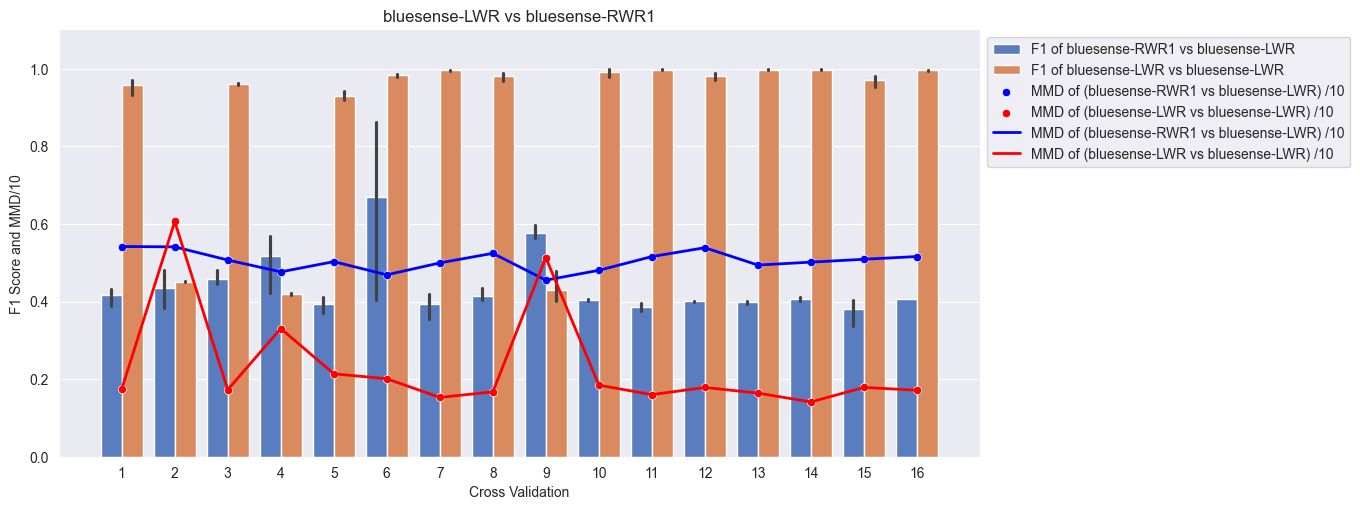

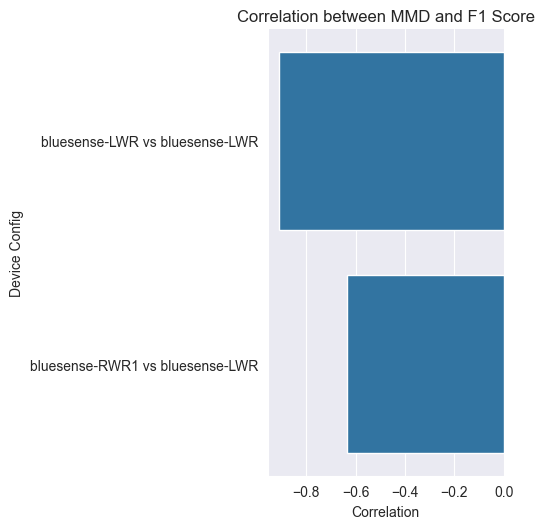

In [6]:
# 17 for real disp
num_participants = 16

corr_data = {}

for pair in sensor_list:
    sensor_test = pair[0]
    sensor_train = pair[1]
    result_list = []

    for i in range(num_participants):
        did_run = True
        for model in ['attend', 'deepconv', 'tinyhar']:
            if sensor_test == "bluesense-RWR1":
                # skip p005 and p017'
                if i == 4 or i == 15:
                    break
            # plot the confusion matrix for each cv
            # create_confusion(root_path, sensor_train, sensor_test, model, i)
            # create_confusion(root_path, sensor_test, sensor_test, model, i)
            result1 = get_result_for_model(root_path, sensor_train, sensor_test, model, i)
            result2 = get_result_for_model(root_path, sensor_test, sensor_test, model, i)

            if result1 == None or result2 == None:
                break

            dict_results = {'f1': result1[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_train + ' vs ' + sensor_test, 'model_type': model}
            result_list.append(dict_results)
            dict_results = {'f1': result2[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_test + ' vs ' + sensor_test, 'model_type': model}
            result_list.append(dict_results)

    df = pd.DataFrame(result_list)

    # plot the f1 score for all participants as bar graph using sns catplot bar with colors red and blue
    sns.catplot(x='cv', y='f1', hue='device_config', data=df, kind='bar', aspect=2, height=5, palette='muted',
                legend_out=False)
    plt.title(sensor_test + ' vs ' + sensor_train)
    plt.xlabel('Cross Validation')
    plt.ylabel('F1 Score and MMD/10')
    # plot max y value is 1.1
    plt.ylim(0, 1.1)

    file_activity = 'using_3d_per_activity'

    # read the mmd values from the csv
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_test + '_' + sensor_test + '.csv')
    mmd_1_1 = pd.read_csv(path)
    # print(mmd_1_1)
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_train + '_' + sensor_test + '.csv')
    mmd_2_1 = pd.read_csv(path)

    '''Using activity here, select which activity to use, 0 for walking, 1 for not walking '''
    mmd_1_1 = mmd_1_1[mmd_1_1['activity'] == 0]
    mmd_2_1 = mmd_2_1[mmd_2_1['activity'] == 0]
    # reset the index
    mmd_1_1 = mmd_1_1.reset_index(drop=True)
    mmd_2_1 = mmd_2_1.reset_index(drop=True)

    # set the CV values to be 1 to len
    len_df = len(mmd_1_1)
    mmd_1_1['CV'] = range(1, len_df + 1)
    mmd_2_1['CV'] = range(1, len_df + 1)

    # if sensor_test is RWR1 then drop cv 17
    if sensor_test == 'bluesense-RWR1':
        # increment CV values greater than 4 by 1
        mmd_1_1.loc[mmd_1_1['CV'] > 4, 'CV'] += 1
        mmd_2_1.loc[mmd_1_1['CV'] > 4, 'CV'] += 1
        mmd_1_1 = mmd_1_1.drop(mmd_1_1[mmd_1_1['CV'] == 16].index)
        mmd_2_1 = mmd_2_1.drop(mmd_2_1[mmd_2_1['CV'] == 16].index)

    # divide the df into two based on device_config
    f1_1_1 = df[(df['device_config'] == 'F1 of ' + sensor_test + ' vs ' + sensor_test)]
    f1_2_1 = df[(df['device_config'] == 'F1 of ' + sensor_train + ' vs ' + sensor_test)]
    # drop model_type
    f1_1_1 = f1_1_1.drop(columns='model_type')
    f1_2_1 = f1_2_1.drop(columns='model_type')
    # drop device_config
    f1_1_1 = f1_1_1.drop(columns='device_config')
    f1_2_1 = f1_2_1.drop(columns='device_config')

    # get the mean of all models for each cv
    f1_1_1 = f1_1_1.groupby('cv').mean()
    f1_2_1 = f1_2_1.groupby('cv').mean()

    # make the cv column the index
    mmd_1_1 = mmd_1_1.set_index('CV')
    mmd_2_1 = mmd_2_1.set_index('CV')

    # finding the corelation between mmd and f1 score for 1_1
    mmd_1_1['f1'] = f1_1_1['f1']
    mmd_2_1['f1'] = f1_2_1['f1']

    # corelation between mmd and f1 score for 1_1
    corr = mmd_1_1.corr()
    # get the correlation between mmd and f1
    # print(corr['mmd']['f1'])
    corr_data[sensor_test + ' vs ' + sensor_test] = corr['mmd']['f1']

    corr = mmd_2_1.corr()
    # get the correlation between mmd and f1
    # print(corr['mmd']['f1'])
    corr_data[sensor_train + ' vs ' + sensor_test] = corr['mmd']['f1']

    # divide MMD value by 10
    mmd_1_1['mmd'] = mmd_1_1['mmd'] / 10
    mmd_2_1['mmd'] = mmd_2_1['mmd'] / 10

    # reset the index to be 0 to len
    mmd_1_1 = mmd_1_1.reset_index()
    mmd_2_1 = mmd_2_1.reset_index()
    # plot the mmd values not only as line but also as points on the graph
    sns.scatterplot(data=mmd_2_1['mmd'], color='blue', label='MMD of (' + sensor_train + ' vs ' + sensor_test + ') /10')
    ax = sns.scatterplot(data=mmd_1_1['mmd'], color='red',
                         label='MMD of (' + sensor_test + ' vs ' + sensor_test + ') /10')
    # plot the mmd values on top of the f1 score. with x as cv, with thickness 2
    sns.lineplot(data=mmd_2_1['mmd'], color='blue', label='MMD of (' + sensor_train + ' vs ' + sensor_test + ') /10',
                 linewidth=2)
    ax = sns.lineplot(data=mmd_1_1['mmd'], color='red', label='MMD of (' + sensor_test + ' vs ' + sensor_test + ') /10',
                      linewidth=2)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    plt.show()

# plot the correlation data
sns.catplot(y=list(corr_data.keys()), x=list(corr_data.values()), kind='bar')
plt.title('Correlation between MMD and F1 Score')
plt.ylabel('Device Config')
plt.xlabel('Correlation')
plt.show()

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

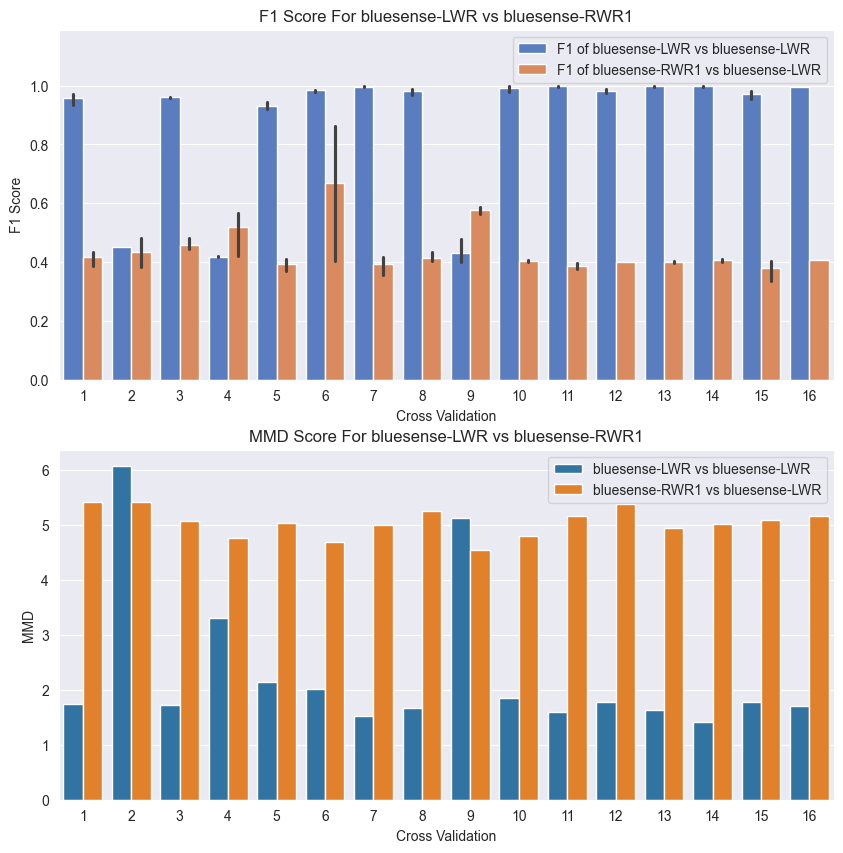

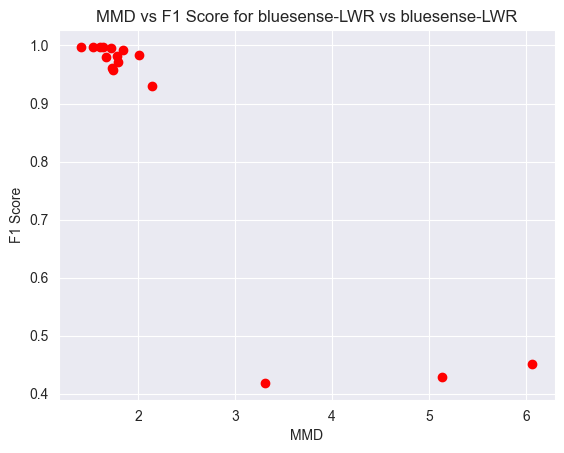

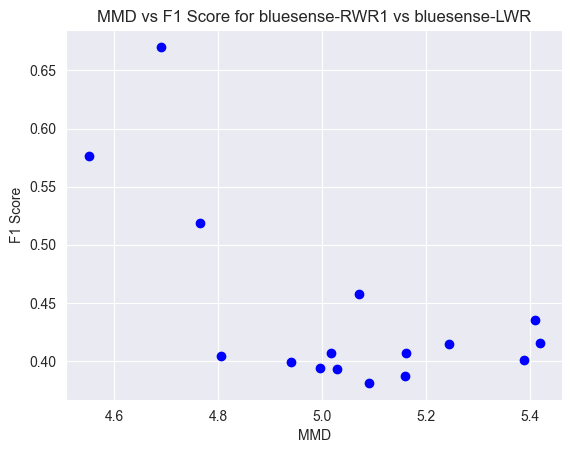

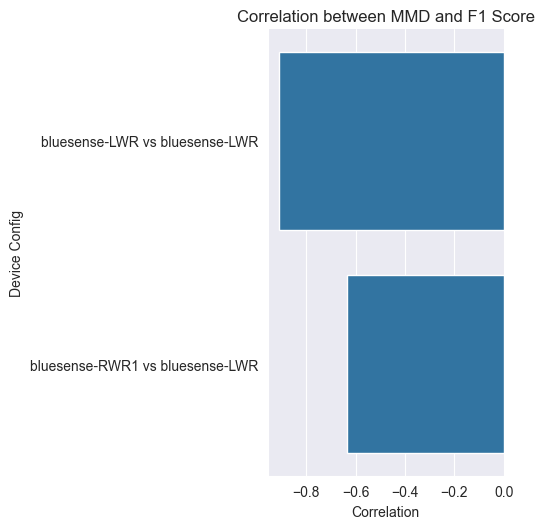

In [7]:
# 17 for real disp
num_participants = 16

corr_data = {}

for pair in sensor_list:
    sensor_test = pair[0]
    sensor_train = pair[1]
    result_list = []

    for i in range(num_participants):
        did_run = True
        for model in ['attend', 'deepconv', 'tinyhar']:
            if sensor_test == "bluesense-RWR1":
                # skip p005 and p017'
                if i == 4 or i == 15:
                    break
            result1 = get_result_for_model(root_path, sensor_train, sensor_test, model, i)
            result2 = get_result_for_model(root_path, sensor_test, sensor_test, model, i)

            if result1 == None or result2 == None:
                break

            dict_results = {'f1': result2[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_test + ' vs ' + sensor_test, 'model_type': model}
            result_list.append(dict_results)
            dict_results = {'f1': result1[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_train + ' vs ' + sensor_test, 'model_type': model}
            result_list.append(dict_results)

    df = pd.DataFrame(result_list)

    # create a vertically divided 2 x 1 graph
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    # plot the f1 score for all participants as bar graph using sns catplot bar with colors red and blue
    sns.barplot(x='cv', y='f1', hue='device_config', data=df, palette='muted',ax=axs[0])
    axs[0].legend(loc='upper right')
    axs[0].set_title('F1 Score For '+ sensor_test + ' vs ' + sensor_train)
    axs[0].set_xlabel('Cross Validation')
    axs[0].set_ylabel('F1 Score')
    # plot max y value is 1.1
    axs[0].set_ylim(0, 1.19)

    file_activity = 'using_3d_per_activity'

    # read the mmd values from the csv
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_test + '_' + sensor_test + '.csv')
    mmd_1_1 = pd.read_csv(path)
    # print(mmd_1_1)
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_train + '_' + sensor_test + '.csv')
    mmd_2_1 = pd.read_csv(path)

    '''Using activity here, select which activity to use, 0 for walking, 1 for not walking '''
    mmd_1_1 = mmd_1_1[mmd_1_1['activity'] == 0]
    mmd_2_1 = mmd_2_1[mmd_2_1['activity'] == 0]
    # reset the index
    mmd_1_1 = mmd_1_1.reset_index(drop=True)
    mmd_2_1 = mmd_2_1.reset_index(drop=True)

    # set the CV values to be 1 to len
    len_df = len(mmd_1_1)
    mmd_1_1['CV'] = range(1, len_df + 1)
    mmd_2_1['CV'] = range(1, len_df + 1)

    # if sensor_test is RWR1 then drop cv 17
    if sensor_test == 'bluesense-RWR1':
        # increment CV values greater than 4 by 1
        mmd_1_1.loc[mmd_1_1['CV'] > 4, 'CV'] += 1
        mmd_2_1.loc[mmd_1_1['CV'] > 4, 'CV'] += 1
        mmd_1_1 = mmd_1_1.drop(mmd_1_1[mmd_1_1['CV'] == 16].index)
        mmd_2_1 = mmd_2_1.drop(mmd_2_1[mmd_2_1['CV'] == 16].index)

    # divide the df into two based on device_config
    f1_1_1 = df[(df['device_config'] == 'F1 of ' + sensor_test + ' vs ' + sensor_test)]
    f1_2_1 = df[(df['device_config'] == 'F1 of ' + sensor_train + ' vs ' + sensor_test)]
    # drop model_type
    f1_1_1 = f1_1_1.drop(columns='model_type')
    f1_2_1 = f1_2_1.drop(columns='model_type')
    # drop device_config
    f1_1_1 = f1_1_1.drop(columns='device_config')
    f1_2_1 = f1_2_1.drop(columns='device_config')

    # get the mean of all models for each cv
    f1_1_1 = f1_1_1.groupby('cv').mean()
    f1_2_1 = f1_2_1.groupby('cv').mean()

    # make the cv column the index
    mmd_1_1 = mmd_1_1.set_index('CV')
    mmd_2_1 = mmd_2_1.set_index('CV')

    # finding the corelation between mmd and f1 score for 1_1
    mmd_1_1['f1'] = f1_1_1['f1']
    mmd_2_1['f1'] = f1_2_1['f1']

    # corelation between mmd and f1 score for 1_1
    corr = mmd_1_1.corr()
    # get the correlation between mmd and f1
    # print(corr['mmd']['f1'])
    corr_data[sensor_test + ' vs ' + sensor_test] = corr['mmd']['f1']

    corr = mmd_2_1.corr()
    # get the correlation between mmd and f1
    # print(corr['mmd']['f1'])
    corr_data[sensor_train + ' vs ' + sensor_test] = corr['mmd']['f1']

    # divide MMD value by 10
    mmd_1_1['mmd'] = mmd_1_1['mmd']
    mmd_2_1['mmd'] = mmd_2_1['mmd']

    # reset the index to be 0 to len
    mmd_1_1 = mmd_1_1.reset_index()
    mmd_2_1 = mmd_2_1.reset_index()

    # combine mmd_1_1 and mmd_2_1 into one dataframe
    mmd = pd.DataFrame()
    # insert columns CV, mmd, config_mmd
    for i in mmd_1_1['CV'].tolist():
        mmd = pd.concat([mmd, pd.DataFrame({'CV': [i], 'mmd': [mmd_1_1[mmd_1_1['CV'] == i]['mmd'].values[0]],
                                            'config_mmd': [sensor_test + ' vs ' + sensor_test]})], ignore_index=True)
        mmd = pd.concat([mmd, pd.DataFrame({'CV': [i], 'mmd': [mmd_2_1[mmd_2_1['CV'] == i]['mmd'].values[0]],
                                            'config_mmd': [sensor_train + ' vs ' + sensor_test]})], ignore_index=True)

    # plot the mmd values on in the other subplot as a bar graph
    sns.barplot(x='CV', y='mmd', hue='config_mmd', data=mmd, ax=axs[1])
    # make legend appear to the right of the graph
    axs[1].legend(loc='upper right')

    axs[1].set_title('MMD Score For '+ sensor_test + ' vs ' + sensor_train)
    axs[1].set_xlabel('Cross Validation')
    axs[1].set_ylabel('MMD')
    plt.show()

    # plot mmd_1_1 mmd vs f1_1_1 f1 score, as points of red color
    plt.scatter(mmd_1_1['mmd'], f1_1_1['f1'], color='red')
    plt.title('MMD vs F1 Score for ' + sensor_test + ' vs ' + sensor_test)
    plt.xlabel('MMD')
    plt.ylabel('F1 Score')
    plt.show()

    # plot mmd_2_1 mmd vs f1_2_1 f1 score, as points of blue color
    plt.scatter(mmd_2_1['mmd'], f1_2_1['f1'], color='blue')
    plt.title('MMD vs F1 Score for ' + sensor_train + ' vs ' + sensor_test)
    plt.xlabel('MMD')
    plt.ylabel('F1 Score')
    plt.show()

# plot the correlation data
sns.catplot(y=list(corr_data.keys()), x=list(corr_data.values()), kind='bar')
plt.title('Correlation between MMD and F1 Score')
plt.ylabel('Device Config')
plt.xlabel('Correlation')
plt.show()

In [8]:
# 17 for real disp
num_participants = 16

corr_final_df = pd.DataFrame()

for pair in sensor_list:
    sensor_test = pair[0]
    sensor_train = pair[1]

    result_list = []
    for i in range(num_participants):
        did_run = True
        for model in ['attend', 'deepconv', 'tinyhar']:
            if sensor_test == "bluesense-RWR1":
                # skip p005 and p017'
                if i == 4 or i == 15:
                    break
            # plot the confusion matrix for each cv
            # create_confusion(root_path, sensor_train, sensor_test, model, i)
            # create_confusion(root_path, sensor_test, sensor_test, model, i)
            result1 = get_result_for_model(root_path, sensor_train, sensor_test, model, i)
            result2 = get_result_for_model(root_path, sensor_test, sensor_test, model, i)

            if result1 == None or result2 == None:
                break

            dict_results = {'f1': result1[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_train + ' vs ' + sensor_test, 'model_type': model}
            result_list.append(dict_results)
            dict_results = {'f1': result2[3],
                            'cv': i + 1,
                            'device_config': 'F1 of ' + sensor_test + ' vs ' + sensor_test, 'model_type': model}
            result_list.append(dict_results)

    df = pd.DataFrame(result_list)

    file_activity = 'using_3d_per_activity'

    # read the mmd values from the csv
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_test + '_' + sensor_test + '.csv')
    mmd_1_1 = pd.read_csv(path)
    # print(mmd_1_1)
    path = os.path.join(root_path, 'data', 'mmd', file_activity,
                        'mmd_results_' + sensor_train + '_' + sensor_test + '.csv')
    mmd_2_1 = pd.read_csv(path)

    '''Using activity here, select which activity to use, 0 for walking, 1 for not walking '''
    mmd_1_1 = mmd_1_1[mmd_1_1['activity'] == 0]
    mmd_2_1 = mmd_2_1[mmd_2_1['activity'] == 0]
    # reset the index
    mmd_1_1 = mmd_1_1.reset_index(drop=True)
    mmd_2_1 = mmd_2_1.reset_index(drop=True)

    # set the CV values to be 1 to len
    len_df = len(mmd_1_1)
    mmd_1_1['CV'] = range(1, len_df + 1)
    mmd_2_1['CV'] = range(1, len_df + 1)

    # if sensor_test is RWR1 then drop cv 17
    if sensor_test == 'bluesense-RWR1':
        # increment CV values greater than 4 by 1
        mmd_1_1.loc[mmd_1_1['CV'] > 4, 'CV'] += 1
        mmd_2_1.loc[mmd_1_1['CV'] > 4, 'CV'] += 1
        mmd_1_1 = mmd_1_1.drop(mmd_1_1[mmd_1_1['CV'] == 16].index)
        mmd_2_1 = mmd_2_1.drop(mmd_2_1[mmd_2_1['CV'] == 16].index)

    # make a dataframe of mmd using mmd_1_1 and mmd_2_1
    mmd = pd.DataFrame()
    mmd['CV'] = mmd_1_1['CV']
    # add the mmd values from mmd_1_1 and mmd_2_1 to mmd dataframe
    mmd['mmd_1_1'] = mmd_1_1['mmd']
    mmd['mmd_2_1'] = mmd_2_1['mmd']

    for model in ['attend', 'deepconv', 'tinyhar']:
        # get data only for the model from the df
        df_model = df[df['model_type'] == model]
        for config in ['F1 of ' + sensor_test + ' vs ' + sensor_test, 'F1 of ' + sensor_train + ' vs ' + sensor_test]:
            # get data only for the config from the df
            df_config = df_model[df_model['device_config'] == config]
            # reset index for df_config
            df_config = df_config.reset_index(drop=True)
            corr_data = pd.DataFrame()
            corr_data['cv'] = mmd['CV']

            if config == 'F1 of ' + sensor_test + ' vs ' + sensor_test:
                corr_data['mmd'] = mmd['mmd_1_1']
            else:
                corr_data['mmd'] = mmd['mmd_2_1']

            corr_data['f1'] = df_config['f1']

            # corelation between mmd and f1 score
            corr = corr_data.corr()
            # print(config, model)
            # print(corr['mmd']['f1'])
            sensor_used = sensor_test + '_' + sensor_train
            if sensor_test == 'empatica-left' and sensor_train == 'empatica-right':
                sensor_used = sensor_used + '\n Position Variability'
            elif sensor_test == 'empatica-right' and sensor_train == 'empatica-left':
                sensor_used = sensor_used + '\n Position Variability'
            elif sensor_test == 'empatica-right' and sensor_train == 'bluesense-RWR1':
                sensor_used = sensor_used + '\n Device Variability'
            elif sensor_test == 'empatica-left' and sensor_train == 'bluesense-LWR':
                sensor_used = sensor_used + '\n Device Variability'
            elif sensor_test == 'bluesense-RWR1' and sensor_train == 'bluesense-RWR2':
                sensor_used = sensor_used + '\n Orientation Variability'
            # store the correlation after with f1
            corr['mmd']['f1'] = corr['mmd']['f1'] / df_config['f1'].mean()
            corr_final_df = pd.concat([corr_final_df, pd.DataFrame(
                {'sensors_used': sensor_used, 'device_config': config, 'model_type': model,
                 'correlation': corr['mmd']['f1']}, index=[0])],
                                      ignore_index=True)




C:\Users\Azhar\AppData\Local\Temp\ipykernel_9196\22818409.py:110: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  corr['mmd']['f1'] = corr['mmd']['f1'] / df_config['f1'].mean()
C:\Users\Azhar\AppData\Local\Temp\ipykernel_9196\22818409.py:110: 

In [9]:
corr_final_df

,sensors_used,device_config,model_type,correlation
0,bluesense-LWR_bluesense-RWR1,F1 of bluesense-LWR vs bluesense-LWR,attend,-1.041226
1,bluesense-LWR_bluesense-RWR1,F1 of bluesense-RWR1 vs bluesense-LWR,attend,-1.518819
2,bluesense-LWR_bluesense-RWR1,F1 of bluesense-LWR vs bluesense-LWR,deepconv,-1.040109
3,bluesense-LWR_bluesense-RWR1,F1 of bluesense-RWR1 vs bluesense-LWR,deepconv,-0.995637
4,bluesense-LWR_bluesense-RWR1,F1 of bluesense-LWR vs bluesense-LWR,tinyhar,-1.031431
5,bluesense-LWR_bluesense-RWR1,F1 of bluesense-RWR1 vs bluesense-LWR,tinyhar,-1.164062


D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

Text(0.5, 1.0, 'Correlation between MMD and F1 Score for all models tested')

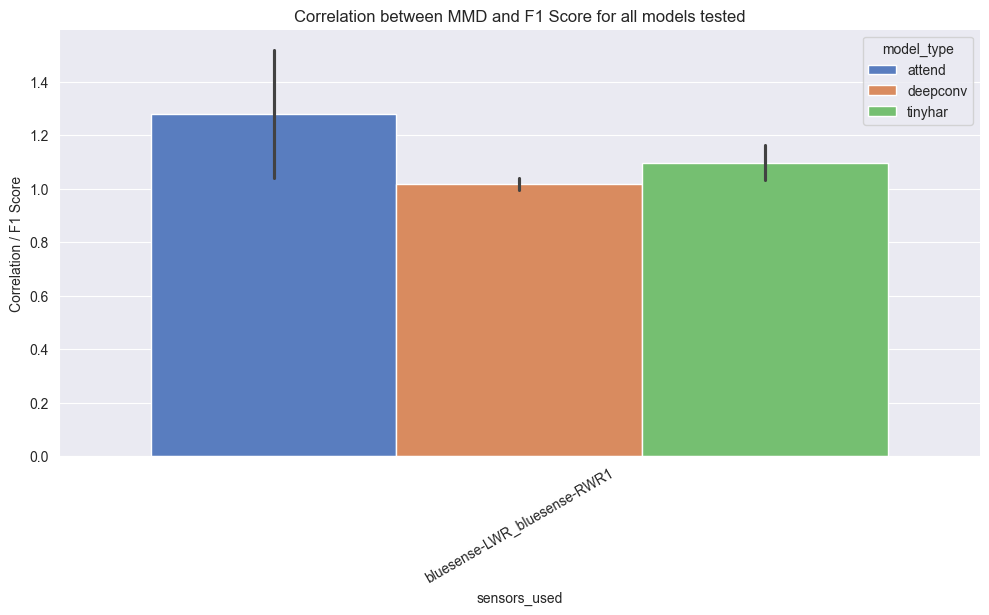

In [10]:
# make all corelation values positive
corr_final_df['correlation'] = corr_final_df['correlation'].abs()
sns.catplot(x='sensors_used', y='correlation', hue='model_type', data=corr_final_df, kind='bar', aspect=2, height=5,
            palette='muted',
            legend_out=False)
# set x labels at 1 30 degree angle
plt.xticks(rotation=30)
plt.ylabel('Correlation / F1 Score')
plt.title('Correlation between MMD and F1 Score for all models tested')
